## Image Classification With Keras Convolutional Neural Network

In [1]:
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from scipy.misc import imresize, imsave

from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

%matplotlib inline

c:\python27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
Using gpu device 0: GeForce GTX 850M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5005)


## Configuration and Hyperparameters

First let's go ahead and define our custom early stopping class, which will be used in the hyperparameters

In [2]:
class EarlyStoppingByLossVal(Callback):
    """Custom class to set a val loss target for early stopping"""
    def __init__(self, monitor='val_loss', value=0.45, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

Then we'll set all the relevant paths and configurations

In [3]:
### paths to training and testing data
train_path = 'C:/Projects/playground/kaggle/dogs_vs_cats/data_no_split/train'
test_path = 'C:/Projects/playground/kaggle/dogs_vs_cats/data_no_split/test'

### path for preloaded vgg16 weights
weights_path = 'C:/Projects/playground/kaggle/dogs_vs_cats/vgg16_weights.h5'
bottleneck_model_weights_path = 'C:/Projects/playground/kaggle/dogs_vs_cats/bottleneck_weights.h5'

### settings for keras early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='auto')
# early_stopping = EarlyStoppingByLossVal(verbose=2, value=0.3)

### other hyperparameters
n_folds = 2
batch_size = 16
nb_epoch = 50
bottleneck_epoch = 3  # used when training bottleneck model
val_split = .15  # if not using kfold cv
classes = ["dog", "cat"]
num_classes = len(classes)

### image dimensions
img_width, img_height = 250, 250
num_channels = 3

## Helper Functions For Loading Data

In [4]:
def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height), cv2.INTER_LINEAR)
    return resized

In [5]:
def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Loading training images...')
    folders = ["dogs", "cats"]
    for fld in folders:
        index = folders.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_images(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)

    print('Training data load time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id

In [6]:
def load_test():
    path = os.path.join(test_path, 'test', '*.jpg')
    files = sorted(glob.glob(path))

    X_test = []
    X_test_id = []
    for fl in files:
        flbase = os.path.basename(fl)
        img = load_images(fl)
        X_test.append(img)
        X_test_id.append(flbase)

    return X_test, X_test_id

In [7]:
def normalize_train_data():
    train_data, train_target, train_id = load_train()

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    train_data = train_data.transpose((0, 3, 1, 2))

    train_data = train_data.astype('float32')
    train_data = train_data / 255
    train_target = np_utils.to_categorical(train_target, num_classes)

    print('Shape of training data:', train_data.shape)
    return train_data, train_target, train_id

In [8]:
def normalize_test_data():
    start_time = time.time()
    test_data, test_id = load_test()

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.transpose((0, 3, 1, 2))

    test_data = test_data.astype('float32')
    test_data = test_data / 255

    print('Shape of testing data:', test_data.shape)
    return test_data, test_id

In [50]:
train_data, train_target, train_id = normalize_train_data()

Loading training images...
Loading dogs files (Index: 0)
Loading cats files (Index: 1)
Training data load time: 340.11 seconds
Shape of training data: (25000L, 3L, 250L, 250L)


## Helper Function For Plotting Images

Function used to plot 9 images in a 3x3 grid (or fewer, depending on how many images are passed), and writing the true and predicted classes below each image.

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
            
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        image = images[i].transpose((1, 2, 0))
        ax.imshow(image)

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Build Model

We use the VGG16 model and pretrained weights for its simplicity and consistent performance

In [ ]:
def build_model():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # load the weights of the VGG16 networks
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    
    # build a classifier model to put on top of the convolutional model
    bottleneck_model = Sequential()
    bottleneck_model.add(Flatten(input_shape=model.output_shape[1:]))
    bottleneck_model.add(Dense(256, activation='relu'))
    bottleneck_model.add(Dropout(0.5))
    bottleneck_model.add(Dense(num_classes, activation='softmax'))
    
    # load weights from bottleneck model
    bottleneck_model.load_weights(bottleneck_model_weights_path)

    # add the model on top of the convolutional base
    model.add(bottleneck_model)

    # set the first 25 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers[:25]:
        layer.trainable = False
        
    # compile the model with a SGD/momentum optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9))
    return model

Before we start training, we use the bottleneck method to extract features from the images in our dataset. We save them as .npy files. 

In [ ]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    # build the VGG16 network
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # load the weights of the VGG16 networks
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    print('Model loaded.')
    
    # create validation split
    X_train, X_valid, Y_train, Y_valid = train_test_split(train_data, train_target, test_size=val_split)

    # create generator for train data
    generator = datagen.flow(
            X_train,
            Y_train,
            batch_size=batch_size,
            shuffle=False)
    
    # save train features to .npy file
    bottleneck_features_train = model.predict_generator(generator, X_train.shape[0])
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

    # create generator for validation data
    generator = datagen.flow(
            X_valid,
            Y_valid,
            batch_size=batch_size,
            shuffle=False)
    
    # save validation features to .npy file
    bottleneck_features_validation = model.predict_generator(generator, X_valid.shape[0])
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)
    return Y_train, Y_valid

Then we train a base model on these features.

In [ ]:
def train_bottleneck_model():
    train_labels, validation_labels = save_bottleneck_features()

    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

    model.fit(train_data,
              train_labels,
              nb_epoch=bottleneck_epoch,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[early_stopping],
              verbose=2)
    
    model.save_weights(bottleneck_model_weights_path)
    return model

In [ ]:
#  train_bottleneck_model()  # leave this commented out once it's been done once -- takes a while to run

## Main Training Function

In [ ]:
def run_train(n_folds=n_folds):
    num_fold = 0
#     sum_score = 0
    models = []   
    callbacks = [
        early_stopping
    ]
    
    ### if we just want to train a single model without cross-validation, set n_folds to 0 or None
    if not n_folds:
        model = build_model()
        
        X_train, X_valid, Y_train, Y_valid = train_test_split(train_data, train_target, test_size=val_split)
        print('Training...')
        print('Size of train split: ', len(X_train), len(Y_train))
        print('Size of validation split: ', len(X_valid), len(Y_valid))
              
        model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          shuffle=True,
          verbose=1,
          validation_data=(X_valid, Y_valid),
          callbacks=callbacks)

        predictions_valid = model.predict(X_valid.astype('float32'), batch_size=batch_size, verbose=2)
#         score = log_loss(Y_valid, predictions_valid)
#         print('Loss: ', score)
#         sum_score += score
        models.append(model)
                     
    else:
        kf = KFold(len(train_id), n_folds=n_folds, shuffle=True, random_state=7)

        for train_index, test_index in kf:
            model = build_model()
            X_train = train_data[train_index]
            Y_train = train_target[train_index]
            X_valid = train_data[test_index]
            Y_valid = train_target[test_index]

            num_fold += 1
            print('Training on fold {} of {}...'.format(num_fold, n_folds))
            print('Size of train split: ', len(X_train), len(Y_train))
            print('Size of validation split: ', len(X_valid), len(Y_valid))

            model.fit(X_train,
                      Y_train,
                      batch_size=batch_size,
                      nb_epoch=nb_epoch,
                      shuffle=True,
                      verbose=1,
                      validation_data=(X_valid, Y_valid),
                      callbacks=callbacks)

#             predictions_valid = model.predict(X_valid.astype('float32'), batch_size=batch_size, verbose=2)
#             score = log_loss(Y_valid, predictions_valid)
#             print('Loss for fold {0}: '.format(num_fold), score)
#             sum_score += score*len(test_index)
            models.append(model)
#         score = sum_score/len(train_data)
        
#     print("Average loss across folds: ", score)
    
    info_string = "{0}fold_{1}x{2}_{3}epoch_patience_vgg16".format(n_folds, img_width, img_height, nb_epoch)
    return info_string, models

## Helper Functions For Making Predictions

In [45]:
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions, columns=classes)
    result.loc[:, 'id'] = pd.Series(test_id, index=result.index)
    result = result[["id", "dog"]].rename(columns={"dog": "label"})
    now = datetime.datetime.now()
    sub_file = info + '.csv'
    result.to_csv(sub_file, index=False)

In [11]:
def merge_several_folds_mean(data, n_folds):
    a = np.array(data[0])
    for i in range(1, n_folds):
        a += np.array(data[i])
    a /= n_folds
    return a.tolist()

In [25]:
def ensemble_predict(info_string, models):
    num_fold = 0
    yfull_test = []
    test_id = []
    n_folds = len(models)

    for i in range(n_folds):
        model = models[i]
        num_fold += 1
        print('Predicting on fold {} of {}'.format(num_fold, n_folds))
        test_data, test_id = normalize_test_data()
        test_prediction = model.predict(test_data, batch_size=batch_size, verbose=2)
        yfull_test.append(test_prediction)

    preds = merge_several_folds_mean(yfull_test, n_folds)
    create_submission(preds, test_id, info_string)

Run the training and prediction code

In [47]:
info_string, models = run_train()
ensemble_predict(info_string)

## Performance Metrics

In [48]:
model = random.choice(models)

### or choose one manually...

# model = models[1]

In [65]:
# perm = np.arange(int(val_split*len(train_target)))
# np.random.shuffle(perm)
# sample_valid = train_data[perm]
# labels_valid = train_target[perm]

ixs = [random.randint(0, len(train_target)) for i in range(1000)]
sample_valid = np.array([train_data[ix] for ix in ixs])
labels_valid = np.array([train_target[ix] for ix in ixs])

In [61]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_validation_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the validation set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the validation set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the validation set that have been
    # incorrectly classified.
    images = sample_valid[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    labels = np.array([classes[np.argmax(x)] for x in labels_valid])
    cls_true = labels[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [62]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_validation_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the validation set.

    # Get the true classifications for the test-set.
    cls_true = [classes[np.argmax(x)] for x in labels_valid]
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred,
                          labels=classes)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [63]:
def print_validation_accuracy(show_example_errors=False,
                              show_confusion_matrix=False):
    
    test_batch_size = 4
    
    # Number of images in the validation set.
    num_test = len(labels_valid)
    
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0
    # iterate through batches and create list of predictions
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = sample_valid[i:j, :]

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = [np.argmax(x) for x in model.predict(images)]

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
    
    # Convenience variable for the true class-numbers of the validation set.
    cls_pred = np.array([classes[x] for x in cls_pred])
    cls_true = np.array([classes[np.argmax(x)] for x in labels_valid])

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on validation set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

Accuracy on validation set: 97.0% (970 / 1000)
Example errors:


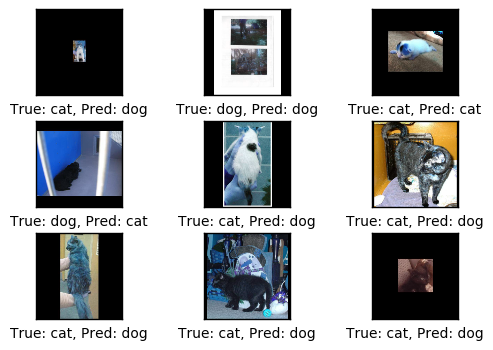

Confusion Matrix:
[[479   6]
 [ 24 491]]


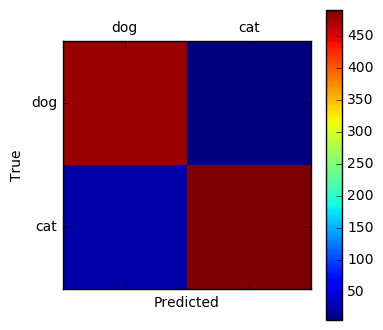

In [66]:
print_validation_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Model Summary & Feature Visualization

In [56]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 252, 252)   0           zeropadding2d_input_5[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 250, 250)  0           zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 252, 252)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 250, 250)  0           zeropadding2d_2[0][0]            
___________________________________________________________________________________________

Processing filter 0
Filter 0 processed in 35s
Processing filter 1
Filter 1 processed in 15s
Processing filter 2
Filter 2 processed in 15s
Processing filter 3
Filter 3 processed in 14s
Processing filter 4
Filter 4 processed in 17s
Processing filter 5
Filter 5 processed in 14s
Processing filter 6
Filter 6 processed in 14s
Processing filter 7
Filter 7 processed in 14s
Processing filter 8
Filter 8 processed in 14s
Processing filter 9
Filter 9 processed in 14s
Processing filter 10
Filter 10 processed in 14s
Processing filter 11
Filter 11 processed in 14s
Processing filter 12
Filter 12 processed in 17s
Processing filter 13
Filter 13 processed in 14s
Processing filter 14
Filter 14 processed in 14s
Processing filter 15
Filter 15 processed in 16s
Processing filter 16
Filter 16 processed in 14s
Processing filter 17
Filter 17 processed in 14s
Processing filter 18
Filter 18 processed in 14s
Processing filter 19
Filter 19 processed in 17s
Processing filter 20
Filter 20 processed in 14s
Processing f

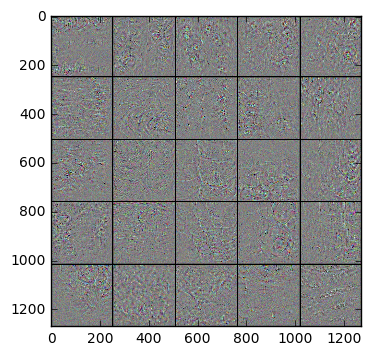

In [57]:
layer_name = 'conv5_3'


# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
for filter_index in range(0, 512):
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering() == 'th':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_dim_ordering() == 'th':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best n**2 filters on a n x n grid.
n = 5

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top n**2 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our n x n filters of size with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save image and display
imsave('feats.jpg', stitched_filters)
plt.imshow(stitched_filters)

## Save Model

In [ ]:
### if we like this model, save the weights

model.save_weights("favorite_model.h5")

## MISC

Script for adding augmented images to dataset using keras ImageDataGenerator

In [ ]:
### augmentation script

# train_path = 'C:/Projects/playground/kaggle/fish/data_aug/train/YFT/'

# ## define data preparation
# datagen = ImageDataGenerator(
#                              width_shift_range=.1,
#                              )

# ## fit parameters from data
# generator = datagen.flow_from_directory(
#                            train_path,
#                            target_size=(512, 512),
#                            class_mode=None,
#                            batch_size=335,
#                            shuffle=True,
#                            save_to_dir=train_path,
#                            save_prefix="aug_"
#                            )


# for X_batch, y_batch in generator:
#     break

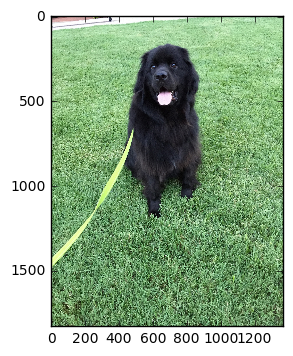

In [74]:
### Test on single image

path_to_lucy = "C:/Projects/playground/neural_style_transfer/images/inputs/content/loo_grass.jpg"

img = load_img(path_to_lucy)
plt.imshow(img)

In [76]:
img = imresize(img, (img_width, img_height))
img = img_to_array(img)

img.shape

(3L, 250L, 250L)

In [85]:
img = img.reshape(1, 3, 250, 250)

print("This is a {0}.".format(classes[model.predict_classes(img)[0]]))

1/1 [==============================] - 0s
This is a dog.
